# This is how I'll want to use the inversion package on simple problems

In [26]:
%matplotlib inline
from __future__ import print_function, division
from future.builtins import super, range
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math, display
import cPickle as pickle
from sklearn.cross_validation import KFold, train_test_split
from fatiando import utils
from inversion import NonLinearModel, Newton, Damping, ACOR, LevMarq

In [66]:
class Cossines(NonLinearModel):
    def __init__(self, nfreq, damping=None):
        super().__init__(nparams=nfreq*3, 
                         optimizer=Newton(initial=np.ones(nfreq*3)))
        self.nfreq = nfreq
        self.damping = damping
        if damping is not None:
            self.config(regularization=[[damping, Damping(self.nparams)]])            
        
    def predict(self, t):
        res = np.sum(a*np.cos(2*np.pi*f*(t - p))
                     for f, a, p in self.p_.reshape(self.nfreq, 3))
        return res
    
    def jacobian(self, t):
        A = np.empty((t.size, self.nparams))
        for i in range(0, self.nparams, 3):
            f, a, p = self.p_[i : i + 3]
            A[:, i] = -2*np.pi*(t - p)*a*np.sin(2*np.pi*f*(t - p))
            A[:, i + 1] = np.cos(2*np.pi*f*(t - p))
            A[:, i + 2] = 2*np.pi*f*a*np.sin(2*np.pi*f*(t - p))
        return A
    
    def fit(self, t, data, **kwargs):
        super().fit(args=[t], data=data, **kwargs)
        return self
    
    @property
    def cossines_(self):
        eq = ' + '.join(
            [r'{:g}\cos(2\pi{:g}(t - {:g}))'.format(a, f, p)
             for f, a, p in self.p_.reshape(self.nfreq, 3)])
        return Math('f(t) = ' + eq)
    
    @property
    def freqs_(self):
        return self.p_.reshape(self.nfreq, 3)[:,0]
    
    @property
    def amps_(self):
        return self.p_.reshape(self.nfreq, 3)[:,1]
    
    @property
    def phases_(self):
        return self.p_.reshape(self.nfreq, 3)[:,2]

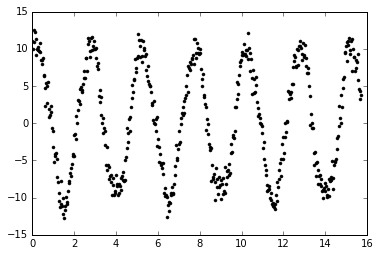

In [98]:
t = np.linspace(0, 5*np.pi, 500)
y = -10*np.cos(2*np.pi*0.4*(t - 1.5)) + 1*np.cos(2*np.pi*1*(t - 10))
yo = utils.contaminate(y, 0.1, percent=True, seed=0)

plt.plot(t, yo, '.k')

<IPython.core.display.Math object>

Freq: [ 1.00329735  1.00329735  1.00329735  1.00329735  1.00329735  1.00329735]
Amp: [ 0.16132  0.16132  0.16132  0.16132  0.16132  0.16132]
CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 66.6 ms


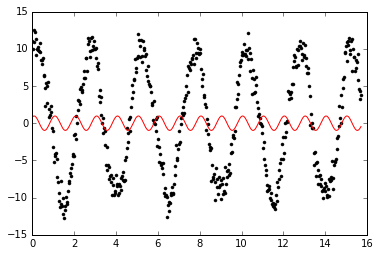

In [99]:
%%time
cls = Cossines(nfreq=6)
cls.config(optimizer=LevMarq(initial=np.ones(cls.nparams))).fit(t, yo)
display(cls.cossines_)
print('Freq:', cls.freqs_)
print('Amp:', cls.amps_)

plt.plot(t, yo, '.k')
plt.plot(t, cls.predict(t), '-r')

<IPython.core.display.Math object>

CPU times: user 1.02 s, sys: 4 ms, total: 1.02 s
Wall time: 1.02 s


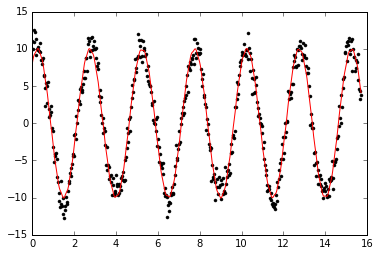

In [104]:
%%time
cls = Cossines(nfreq=2)
cls.config(optimizer=ACOR([0, 10, -100, 100, 0, 20]*cls.nfreq, cls.nparams, 
                          nants=3, maxit=1000, seed=0)).fit(t, yo)
display(cls.cossines_)

plt.plot(t, yo, '.k')
plt.plot(t, cls.predict(t), '-r')